# Generate Model Climatology

---

This notebook takes in the `.zarr` raw S2S array we made in `1_download_data.ipynb` and generates a daily climatology (with band pass filtering) to remove from the raw S2S output to create anomalies.

In [1]:
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import dask.array as da
import cftime
from datetime import datetime

from dask.distributed import Client

In [2]:
client = Client("tcp://128.117.208.176:41677")

Choose which model and variables you are wanting in your climatology `zarr` file.

In [3]:
# model = "cesm2cam6v2"
model = "cesm2cam6climoOCNclimoATM"

#var = ["t2m","tp","gh_500","psl"]
var = ["TREFHT"]

First, we need to calculate the daily climatology following the SubX protocol. We'll load in our big `zarr`, take the ensemble mean, and then generate the climatology.

In [4]:
# ds = xr.open_zarr("/glade/campaign/mmm/c3we/jaye/S2S_zarr/"+model+".raw.daily.geospatial.zarr",consolidated=True)
ds = xr.open_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6climoOCNclimoATM.raw.daily.TREFHT.geospatial.zarr",consolidated=True)
display(ds)

<xarray.Dataset> Size: 128GB
Dimensions:  (member: 11, init: 1148, lead: 46, lat: 192, lon: 288)
Coordinates:
  * init     (init) datetime64[ns] 9kB 1999-01-04 1999-01-11 ... 2020-12-28
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lead     (lead) int64 368B 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44 45
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member   (member) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    TREFHT   (member, init, lead, lat, lon) float32 128GB dask.array<chunksize=(11, 1, 46, 192, 288), meta=np.ndarray>

Here I "persist" the ensemble mean. This essentially runs the calculation in the background, but maintains the result as dask arrays distributed across the cluster, rather than loading it into RAM memory on the main node.

In [5]:
ds = ds.mean("member").persist()

## Generate Climatology

We'll be taking an average over the `dayofyear` of the `init` dimension, so it's best to rechunk so that `init` is a single chunk. That will speed things up. I'll make `lead` chunks of 1 since we are doing a lead-dependent climatology.

I usually run `.persist()` after re-chunking so that it can re-load it's chunks properly.

In [6]:
ds = ds.chunk({"init": -1, "lead": 1, "lat": "auto", "lon": "auto"}).persist()

All of the following is from Ray Bell's climatology script for SubX that Kathy uses. Direct questions to them about the methodology! This uses a smoothed window approach to smooth out the daily climatology for initializations.

In [7]:
ds.groupby("init.dayofyear").mean("init")

<xarray.Dataset> Size: 4GB
Dimensions:    (dayofyear: 366, lead: 46, lat: 192, lon: 288)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lead       (lead) int64 368B 0 1 2 3 4 5 6 7 8 ... 38 39 40 41 42 43 44 45
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    TREFHT     (dayofyear, lead, lat, lon) float32 4GB dask.array<chunksize=(366, 1, 139, 209), meta=np.ndarray>

## Loop through all vars to make climatology

In [8]:
da_day_clim_smooth_vars = []
for i in var:
    print(i)
    da_day_clim = ds[i].groupby("init.dayofyear").mean("init")
    days = da_day_clim.shape[0]
    # Rechunk to make dayofyear climatology one chunk.
    da_day_clim = da_day_clim.chunk({"dayofyear": days}).persist()
    # Just mimicking the chunk sizes from our climatology.
    x = da.full((days, da_day_clim.lead.size, da_day_clim.lat.size, da_day_clim.lon.size),
        np.nan,dtype="float32",chunks=(days, 1, 181, 360),)
    # Pad the daily climatolgy with nans
    _da = xr.DataArray(x,dims=["dayofyear", "lead", "lat", "lon"],
        coords=[da_day_clim.dayofyear, da_day_clim.lead, da_day_clim.lat, da_day_clim.lon],name=i,)
    # Pad the daily climatolgy with nans
    da_day_clim_wnan = da_day_clim.combine_first(_da)
    # Period rolling twice to make it triangular smoothing
    da_day_clim_smooth = da_day_clim_wnan.copy()
    
    for j in range(2):
        # Extand the DataArray to allow rolling to do periodic
        da_day_clim_smooth = xr.concat([da_day_clim_smooth[-15:], da_day_clim_smooth, da_day_clim_smooth[:15]],"dayofyear",)
        # Rolling mean
        da_day_clim_smooth = da_day_clim_smooth.rolling(dayofyear=31, center=True, min_periods=1).mean()
        # Drop the periodic boundaries
        da_day_clim_smooth = da_day_clim_smooth.isel(dayofyear=slice(15, -15))
        
    # Extract the original days
    da_day_clim_smooth = da_day_clim_smooth.sel(dayofyear=da_day_clim.dayofyear)
    da_day_clim_smooth.name = i
    
    da_day_clim_smooth_vars.append(da_day_clim_smooth)

TREFHT


- Next we need to merge the variables together into one xarray dataset.

In [9]:
ds_day_clim_smooth_vars = xr.merge(da_day_clim_smooth_vars)

In [10]:
ds_day_clim_smooth_vars

<xarray.Dataset> Size: 4GB
Dimensions:    (lat: 192, lead: 46, lon: 288, dayofyear: 366)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lead       (lead) int64 368B 0 1 2 3 4 5 6 7 8 ... 38 39 40 41 42 43 44 45
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    TREFHT     (dayofyear, lead, lat, lon) float32 4GB dask.array<chunksize=(350, 1, 139, 209), meta=np.ndarray>
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

In [11]:
ds_day_clim_smooth_vars = ds_day_clim_smooth_vars.chunk({"dayofyear": -1, "lead": 1, "lat": 181, "lon": 360}).persist()

In [12]:
ds_day_clim_smooth_vars

<xarray.Dataset> Size: 4GB
Dimensions:    (lat: 192, lead: 46, lon: 288, dayofyear: 366)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lead       (lead) int64 368B 0 1 2 3 4 5 6 7 8 ... 38 39 40 41 42 43 44 45
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    TREFHT     (dayofyear, lead, lat, lon) float32 4GB dask.array<chunksize=(366, 1, 181, 288), meta=np.ndarray>
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

- Now we write out to `zarr`!

In [13]:
%time ds_day_clim_smooth_vars.to_zarr("/glade/derecho/scratch/mdfowler/temp/S2S_zarr/cesm2cam6climoOCNclimoATM.climatology.daily.TREFHT.geospatial.zarr", mode="w",consolidated=True)


CPU times: user 59.2 ms, sys: 17.1 ms, total: 76.3 ms
Wall time: 12.3 s


Just a quick check that things look right.

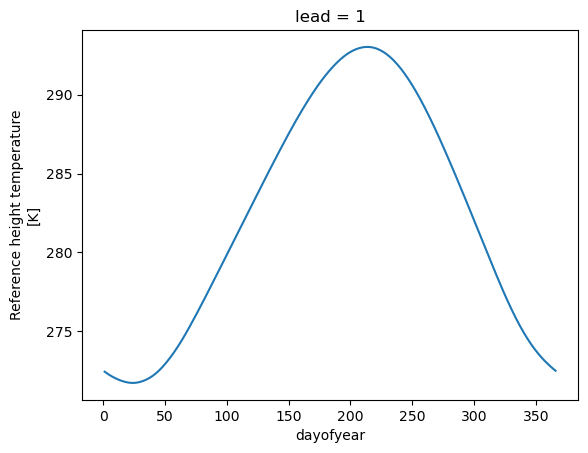

In [14]:
ds_day_clim_smooth_vars.TREFHT.sel(lead=1,lat=slice(31,60)).mean(("lat","lon")).plot()

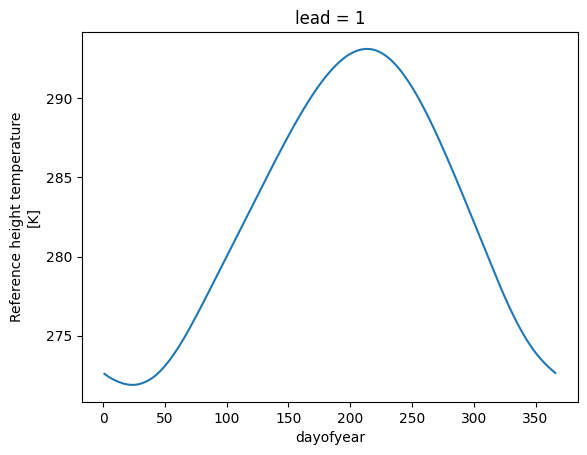

2025-02-18 14:10:26,154 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [14]:
ds_day_clim_smooth_vars.t2m.sel(lead=1,lat=slice(31,60)).mean(("lat","lon")).plot()